<a href="https://colab.research.google.com/github/kpjaskie/SenSIP21/blob/main/5_Machine_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Algorithms

*By Kristen Jaskie, July 2020*

In this notebook, we will be performing different classification algorithms for comparison on simulated and real-world datasets.

In statistics and machine learning, classification is the problem of identifying to which of a set of categories or classes a new observation belongs.  This is done by creating a model from data whose class membership is known.  When the data belongs to one of two classes, this is refered to as **binary classification**.  When there are more than two classes represented,, this is called **multi-class classification**.

Examples of **binary classification** include determining whether an email is "spam" or "non-spam" or determining if a patient "is pregnant" or "is not pregnant".

Examples of **multi-class classification** include determening what is causing a patients illness (out of many possible diseases) based on observed characteristics of the patien (sex, blood pressure, presence or absence of certain symptoms, etc.) or identifying an animal, plant, or make and model of vehicle in a photograph.

![picture](https://miro.medium.com/max/972/1*SwXHlCzh-d9UqHOglp3vcA.png)

In this tutorial, we will mostly focus on binary classification using simulated datasets.  However, we will introduce some real-world examples towards the end.


In [51]:
# First, we need to import the relavent libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec

# To create simulated data
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.model_selection import train_test_split

# To create confusion matrices and metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns; sns.set()  # for plotting confusion matrices
from tabulate import tabulate


# Generate Data

Let's make some simulated data to work with.  As mentioned above, we will start with only two classes so that we can perform binary classification.  In binary classification, we often name the classes "positive" and "negative".  If one of the classes is smaller than the other, it is typically called the positive class.

In this example, the classes are the same size but the degree of separability (how well separated the classes are from one another) is based on the standard deviation for each cluster.  Try different sized data clusters and different standard deviations below to see how it affects the data.  **Good values for this dataset are around 300-500 datapoints with a standard deviation around 0.75.**

The classifier models that we'll learn below will perform best if the data is well separated, but of course in the real world, this isn't usually an option.

*Note: The slide-bar is a type of google form.  If you want to see the code behind this data generation, double-click anywhere near the slide-bar.*

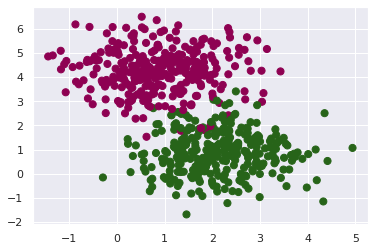

In [31]:
#@title Generate binary data

Dataset_Size = 620 #@param {type:"slider", min:50, max:1000, step:10}
Standard_Deviation = 0.91 #@param {type:"slider", min:0, max:2, step:0.01}

#Let's make simple data to classify.
X, y = make_blobs(n_samples=Dataset_Size, 
                  centers=2, 
                  random_state=0, 
                  cluster_std=Standard_Deviation)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG');

From this, we can clearly see the two well defined classes of data - red and green.



## Break into train/validation/test sets
Before we can train a model on this data, we want to **RANDOMLY** break the data into training, validation, and test sets.  By breaking it apart in this manner, we will be able to effectively predict how accurate our model is.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1ddNmMNHGaFYrhH_MwSs0iGfDVSxW3jjG" width="700"/>
</div>
</center>

Some of the algorithms we will be looking at in this notebook (most noteably Logistic Regression) will have very few hyperparameters that can be modified.  Despite this, we will still use a training, validation, and test set to maintain supervised learning best practices. 

Machine Learning practitioners usually use a slightly more complex type of validation called **cross-validation**.  While this is a more effective technique than standard validation, for simplicity and clarity, we will use standard validation (shown above) in this notebook.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1_r4qBkrZM_Z-nVr8i1c6ShGlVSPlMOGo" width="400"/>
</div>
</center>

With cross-validation, the test data is removed at the beginning and not used until the end, but the rest of the data is split so that every  datapoint will at some point be part of the validation data.  This helps minimize the impacts of any outliers.
<br/><br/>
<center>
* * *
</center>

Notice that since the built in sklearn function "train_test_split" only breaks the sets into two parts, we have to use the function twice to get three sets.
* Once to separate the initial training data.
* Again to separate the validation and test sets from the remaining data.

In [32]:
#Here, our training set is composed of 70% of the data and our validation
#and test sets are each composed of 15% of the data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.5)

#Combine training and validation sets for final classification when we're ready 
#for our final classification after validation training/testing.
X_final_train = np.concatenate((X_train, X_val), axis=0)
y_final_train = np.concatenate((y_train, y_val), axis=0)

print("Training Size   = ", X_train.shape[0])
print("Validation Size = ", X_val.shape[0])
print("Test Size       = ",  X_test.shape[0])

Training Size   =  434
Validation Size =  93
Test Size       =  93


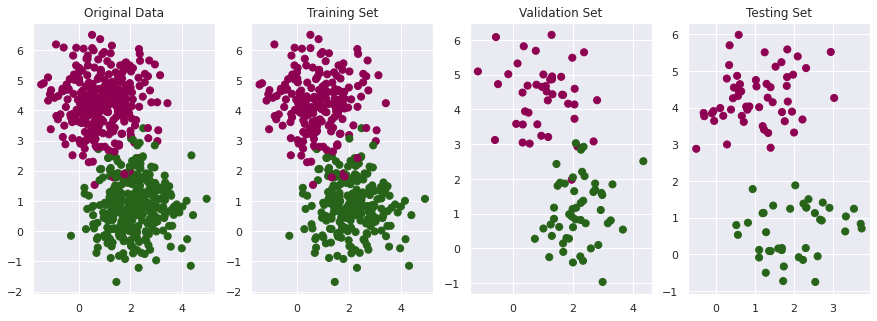

In [33]:
#@title Visualize Sets
fig, ax = plt.subplots(1, 4, 
                       gridspec_kw={
                           'width_ratios': [2, 2, 2, 2],
                           'height_ratios': [1]},
                       figsize=(15,5))

ax[0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG');
ax[0].set_title('Original Data')

ax[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG');
ax[1].set_title('Training Set')

ax[2].scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=50, cmap='PiYG');
ax[2].set_title('Validation Set')

ax[3].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG');
ax[3].set_title('Testing Set')

plt.show()


# Evaluating a Classification Algorithm

Before we begin working with classification algorithms, we need to introduce some of the standard classification evaluation techniques so we will be able to differentiate a good classification model from a bad one.

We will discuss:
* Confusion Matrices
* Metrics including Accuracy, Recall, Precision, and F-score (also called the F1-score).


## Confusion Matrices

Machine Learning practitioners' first tool for evaluating classification models is to generate and inspect the confusion matrix.  A confusion matrix for a binary classification problem has two rows and two columns. The real answers often depicted as the columns and the model predicted answers are given as the rows, but this is not always true - you have to look at the axis labels to be sure.
<br/><br/>

The image below depicts a confusion matrix for a pregnancy test.  A real confusion matrix will have numbers in each cell showing how many data samples your classification model classified into each category: True Positives (TP), False Positives (FP), False Negatives (FN), or True Negatives (TN).

<div>
<img src="http://drive.google.com/uc?export=view&id=1qAFkAshy_JCGORVioC1sMaVZXKVLsJLn" width="600"/>
</div>





Ideally, we'd like to have a confusion matrix where the True Positives and True Negatives were high and the False Positives and False Negatives were low.  When this is true, the diagnonal from top left to bottom right would have large numbers and everywhere else would be low.
<br/><br/>
**IMPORTANT: The orientation of a confusion matrix is NOT standard and some places such as Wikipedia have the postives in the first row and some places like sklearn have the negatives in the first row.  You MUST read the axis to understand the confusion matrix.  In the plot below, and in future python examples, the orientation is:**

\begin{bmatrix}
TN & FP \\
FN & TP 
\end{bmatrix}


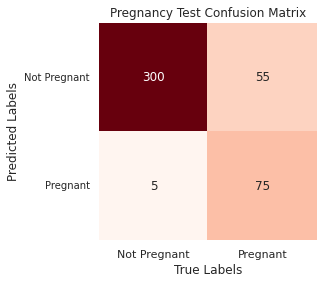

In [34]:
#@title  Confusion Matrix Example
#@markdown The following is an example confusion matrix that has been 
#@markdown generated in Python.  Notice that the row and column
#@markdown labels have been swapped from the image above.  **It
#@markdown is important to always pay attention to these labels.**

TP_preg =  75
FP_preg =  5
FN_preg =  55
TN_preg =  300

y_real = np.concatenate((np.ones((TP_preg+FN_preg,)), 
                         np.zeros((TN_preg+FP_preg,))))
y_predicted = np.concatenate((np.ones((TP_preg,)), 
                              np.zeros((FN_preg + TN_preg,)), 
                              np.ones((FP_preg,))))

CM_example = confusion_matrix(y_real, y_predicted)

ax = sns.heatmap(CM_example.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Reds")

ax.set_xticklabels(('Not Pregnant','Pregnant'))
ax.set_yticklabels(('Not Pregnant','Pregnant'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Pregnancy Test Confusion Matrix")
plt.show()

## Evaluation Metrics

While the confusion matrices described above are increadibly useful in evaluating how your model is performing, sometimes it's nice to have a **summary statistic** or a single value to evaluate your model.  These are often called **metrics**.  Here, we're going to go through the most commonly used classification metrics.  These metrics all use the TP, FP, TN, and FN shown in the confusion matrix above.

### Accuracy

A model's accuracy is probably the most commonly used classification metric.  

The accuracy is calculated as:
$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$

This accuracy can either be calculated manually using this formula, or you can ask sklearn to calculate it for you.  

```
#Manual Calculation
accuracy = (TP + TN)/(TP + FP + TN + FN)
```

```
#Sklearn Calculation
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_real, y_predicted)
```


### Precision and Recall

Two other important metrics that are commonly used are the Precision and the Recall.  

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1A-x7MJeGDoQrxKXWfGZXpKoLDahUHHhq" width="700"/>
</div>
</center>

Precision and recall are important in many applications and models can be adjusted to increase one, often at the expense of the other.

* For example, when predicting a deadly disease, doctors might prefer to scare somebody with a false positive instead of missing somebody through a false negative.  In this case, having a high recall is preferred to precision.

* In other cases, such as when a credit card company declines a credit card due to suspected fraud, they're going to make their customers very unhappy if there was no fraud.  In this case, the credit card company would prefer a higher precision over a high recall.

Understanding the differences and tradeoffs between these two metrics, helps a data scientist focus on what's best for the situation.

The Precision and Recall can either be calculated manually or using sklearn.

```
#Manual Calculation
precision = TP/(TP + FP)
recall = TP/(TP + FN)
```

```
#Sklearn Calculation
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_real, y_predicted)
recall = recall_score(y_real, y_predicted)
```

### F-Score

The F-score (called the F1-score in statistics) is a number between 0 and 1 that equals the harmonic mean between recall and precision.  This means that it is high when both precision and recall are high and low if either one is low.  It is often used as an alternative to accuracy.
<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1EXsN_2shynQxzJE3Lvj8yWSkX8Kb9SwD" width="300"/>
</div>
</center>

When your class sizes are pretty similar, accuracy is an extremely useful metric.  But when your class sizes are skewed (meaning they have very different sizes), the F-score is a better metric.

Example:
* Your data contains 990 negative samples and only 10 positive samples. Your classifier always predicts that everything is negative, you will have an accuracy of 99%.
* So is this a *useful* classifier?  No!  Despite having 99% accuracy, this classifier is worthless.  This is better captured by the F-score which equals zero in this scenario.

When the class sizes are the same, the accuracy and the F-score will be similar.

The F-Score can either be calculated manually or using sklearn.

```
#Manual Calculation
fscore = 2 * (precision * recall)/(precision + recall)
```

```
#Sklearn Calculation
from sklearn.metrics import f1_score
fscore = f1_score(y_real, y_predicted)
```

## Experimentation

Now that you've learned about the different classification evaluation metrics, let's play with some numbers.  For simplicity, we're going to use disease **X** diagnosis as an example.  We will define those with the disease to be  **positive** and those without to be **negative**.

Remember: 
* TP = Has **X** classified as having **X (correct)**
* FP = Does not have **X** but classified as having **X (incorrect)**
* FN = Has **X** but classified as not having **X (incorrect)**
* TN = Does not have **X** and classified as not having **X (correct)**






Metric     Value
---------  -------
Accuracy   0.93
Precision  0.99
Recall     0.93
F-score    0.96



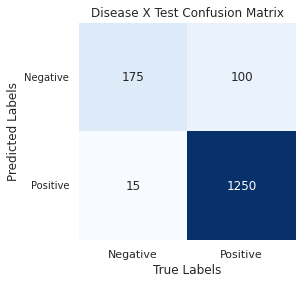

In [35]:
#@title Data

TP =  1250#@param {type:"integer"}
FP =  15#@param {type:"integer"}
FN =  100#@param {type:"integer"}
TN =  175#@param {type:"integer"}

y_real = np.concatenate((np.ones((TP+FN,)), np.zeros((TN+FP,))))
y_predicted = np.concatenate((np.ones((TP,)), np.zeros((FN + TN,)), 
                              np.ones((FP,))))

#@title Results
accuracy_ex = round((TP + TN)/(TP + FP + TN + FN), 2)

if TP == 0 and FP == 0:
    precision_ex = 0
else:
    precision_ex = round(TP/(TP + FP), 2)

if TP == 0 and FN == 0:
    recall_ex = 0
else:
    recall_ex = round(TP/(TP + FN), 2)

if precision_ex == 0 and recall_ex == 0:
    fscore_ex = 0
else:
    fscore_ex = round(2 * (precision_ex * recall_ex)/(precision_ex + recall_ex), 2)

print(tabulate([['Accuracy', accuracy_ex], 
                ['Precision', precision_ex],
                ['Recall', recall_ex],
                ['F-score', fscore_ex],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_example = confusion_matrix(y_real, y_predicted)

ax = sns.heatmap(CM_example.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Negative', 'Positive'))
ax.set_yticklabels(('Negative', 'Positive'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Disease X Test Confusion Matrix")
plt.show()

### Some Things to Try

In the data fields above, see if you can change the TP, TN, FP, FN so that you get:
1.   The accuracy to equal 75%.
2.   The precision and recall to be less than 1 but equal to one another.
3.   The F-score to be greater than the accuracy.

# Logistic Regression

When classifying data using logistic regression, the classifier will calculate the probability that each datapoint belongs to the positive class.

Logistic regression works by fitting data to a sigmoid function.  The logit sigmoid function has the following equation:

$$Sigmoid(x)=\frac{1}{1+e^{-\theta x}}$$

If we were to plot this, we would get the following curve.

<center>
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" width="300"/>
</div>
</center>

You can think of this as taking a linear model of **binary** data and converting it to probabilities between zero and one.  

## Example

Let's see an example of this to understand the intuition behind this techique.

Here's an example of test scores for a difficult test based on the number of hours each student studied.  Noice the students who passed the test are marked in green and the students who failed are marked in red.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1J-yVXGpzgb4tasjngwPpMK1fDyOyPn5i" width="300"/>
</div>
</center>

Now we could just perform a linear regression and try to predict what score a person would get given their hours of study, but while the data is sort of linear in a diagonal from the lower left to the upper right of the graph, it is not a very strong relationship.  

Instead, we're going to create a logistic regression model for the classes - students who passed vs those that did not pass.  To do this, let's just look at the pass/fail information.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1SpgYf4zWsLFOJNYilCpZf5wbV6NgHXXb" width="400"/>
</div>
</center>
<br/><br/>
Now we *could* fit a line to this information...

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1RabrQX2cxjyq4XANWt_panMPULNQUEbJ" width="400"/>
</div>
</center>

But notice that not only does this not fit the data well, but we also can't use this to directly calculate the probability of passing the test because this line goes below zero and above one which isn't possible for probabilities. 


The equation for this particular line is:
$$
z = 0.185x - 0.29
$$
<br/><br/>
But if we make this the input to our sigmoid function:

$$
Sigmoid(z)=\frac{1}{1+e^{-(0.185x - 0.29)}}
$$

we'll get the probabilistic output that we're looking for.  This becomes a function for the probability that a student will pass, given the amount of hours they'll study.

<br/><br/>
<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1UWDMYrOUtaxwiz2Nbv5eN9KRxItYl2Hy" width="400"/>
</div>
</center>

Notice that unlike the straight line above, this sigmoid never goes below zero or above 1, meaning it creates well calibrated probabilities.

<center> * * * </center>


Another way of thinking about this is to imagine increasing the dimensionality of the problem by adding a new axis that contains the probability of a student passing given the number of hours they studied.





<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1AcFnFx712ck-DxJdChaxcYKl91AjK--_" width="300"/>
</div>
</center>



## Logistic Regression on Simulated Data

So now let's see how we can go about implementing this classifier on the simulated data generated at the top of this notebook.  It is reproduced here as well.  

You can always go back up and reset the standard deviation and dataset size to see what effect they will have.

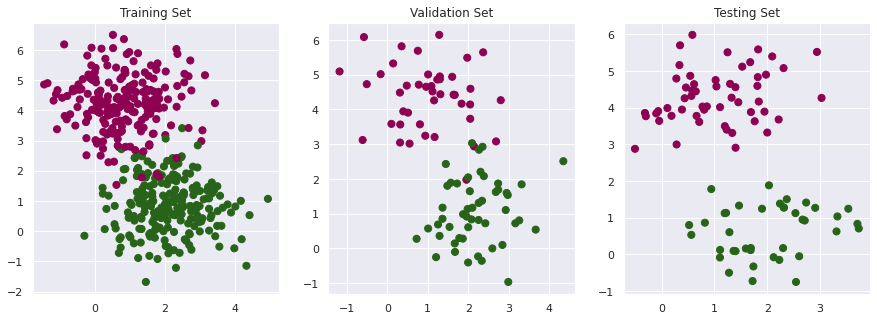

In [36]:
#@title Visualize Sets
fig, ax = plt.subplots(1, 3, 
                       gridspec_kw={
                           'width_ratios': [2, 2, 2],
                           'height_ratios': [1]},
                       figsize=(15,5))

ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG');
ax[0].set_title('Training Set')

ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=50, cmap='PiYG');
ax[1].set_title('Validation Set')

ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG');
ax[2].set_title('Testing Set')

plt.show()

Now, we're going to learn a model of the test data.

The hyperparameters for this logistic regression model are the solver and maximum number of itterations.  On this small dataset however, changing these options probably won't make a significant difference.

* solver choices: ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, and ‘saga’
* max_itr: The maximum number of itterations before the model stops learning.


In [14]:
LR_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=200)
LR_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

That's it!  We've created a model!  Now let's use it to predict the labels of the validation set.  

The solid datapoints in the image below are the validation set that we're testing our model on.  The light points are the test data.

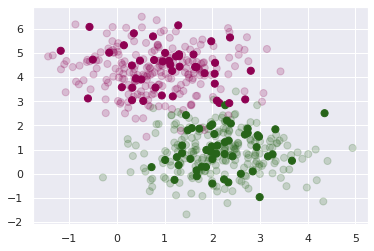

In [37]:
y_hat_lr = LR_model.predict(X_val) #lr stands for logistic regression

plt.figure(0)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_hat_lr, s=50, cmap='PiYG');
#plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=200, cmap='PiYG', alpha=0.2);

Now let's evaluate our model by calculating its confusion matrix and summary statistics.  Notice that the more overlap between the red and green classes, the lower the effectiveness of the model.

Metric     Value
---------  -------
Accuracy   0.97
Precision  0.98
Recall     0.96
F-score    0.97

TP:  48


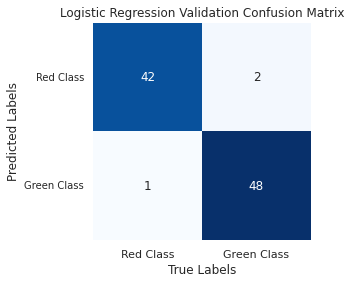

In [38]:
#@title Validation Evaluation
accuracy_logistic = round(accuracy_score(y_val, y_hat_lr), 2)
precision_logistic = round(precision_score(y_val, y_hat_lr), 2)
recall_logistic = round(recall_score(y_val, y_hat_lr), 2)
fscore_logistic = round(f1_score(y_val, y_hat_lr), 2)

print(tabulate([['Accuracy', accuracy_logistic], 
                ['Precision', precision_logistic],
                ['Recall', recall_logistic],
                ['F-score', fscore_logistic],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_logistic = confusion_matrix(y_val, y_hat_lr)
tn, fp, fn, tp = CM_logistic.ravel()
print('TP: ', tp)

ax = sns.heatmap(CM_logistic.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Logistic Regression Validation Confusion Matrix")
plt.show()

Now it's our chance to go back and modify the model hyperparameters until we get the best validation accuracy we can get.  

The hyperparameters for this logistic regression model are the solver and maximum number of itterations.
* solver choices: ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, and ‘saga’
* max_itr: The maximum number of itterations before the model stops learning.

In more complex problems, some of the other possible logistic regression parameters (such as the regularization parameter C).  Please see the documentation for more information.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Perform Final Logistic Regression on the Test Set

Once you've tuned the hyperparameters in the model above to get the best possible results on the validation set (this probably won't be much work for this dataset), it's time to combine the original training and validation sets and create a new, final model.  We will then test this final model on our test set to estimate our model's effectiveness.

In [39]:
#Create final model
LR_model_final = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100)
LR_model_final.fit(X_final_train, y_final_train)

#Use the final model to predict the test data
y_hat_lr_final_test = LR_model_final.predict(X_test)

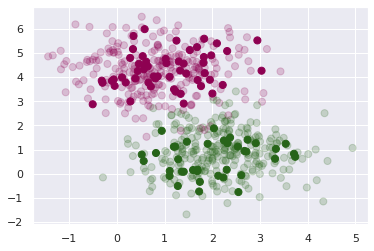

Metric     Value
---------  -------
Accuracy   1.0
Precision  1.0
Recall     1.0
F-score    1.0



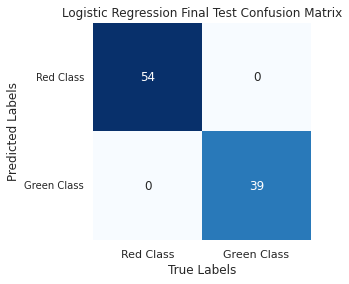

In [40]:
#@title Evaluate Final Model

plt.figure(0)
plt.scatter(X_final_train[:, 0], X_final_train[:, 1], c=y_final_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_lr_final_test, s=50, cmap='PiYG');
plt.show()

accuracy_logistic_final = round(accuracy_score(y_test, y_hat_lr_final_test), 2)
precision_logistic_final = round(precision_score(y_test, y_hat_lr_final_test), 2)
recall_logistic_final = round(recall_score(y_test, y_hat_lr_final_test), 2)
fscore_logistic_final = round(f1_score(y_test, y_hat_lr_final_test), 2)

print(tabulate([['Accuracy', accuracy_logistic_final], 
                ['Precision', precision_logistic_final],
                ['Recall', recall_logistic_final],
                ['F-score', fscore_logistic_final],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_logistic = confusion_matrix(y_test, y_hat_lr_final_test)

ax = sns.heatmap(CM_logistic.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Logistic Regression Final Test Confusion Matrix")
plt.show()

#Support Vector Machines

A Support Vector Machine, or SVM, is a popular traditional classification algorithm.  In this algorithm, the **margin** around the **hyperplane** separating the classes is maximized.  A hyperplane is defined as a surface that has one fewer dimension than the data.  So if the data is 2d (as in the following examples and the data we're using today), a hyperplane with be 1d (a line).  If the data were 3d, then its associated hyperplanes would be 2d surfaces, and so on.

This is an image of two dimensional data with several possible hyperplanes shown in black.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1M3dro14Uju6d7ohXKyGiqJoeSI7--yVM" width="300"/>
</div>
</center>

The SVM finds the hyperplane with the widest **margin** or gap around it.  The datapoints that define the margin are called **support vectors**.

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1W7FaOXy0_6xS6vFKBWRmNZBWNx9MIrJY" width="700"/>
</div>
</center>


Kernels are commonly used with SVMs to add nonlinearity through additional calculated features to increase the data dimensionality.  SVMs are most effective when the data is well separated and can be ineffective and very slow when the data is not.  In these cases, the algorithm becomes more difficult.

Imagine the following dataset.  Clearly a linear hyperplane will not be able to separate the two sets!  One way to deal with this is to add a kernel.  There are many types of kernels, but one of the more common ones is called a Gaussian kernel.  To do this, we add "landmarks" to the dataset.  In this case, I've added a landmark (black dot) to the very center of the dataset.  

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=18Ot1HwXsQsWA-pHWEykr5XTSCve4gOS6" width="300"/>
</div>
</center>

We can now introduce a third dimension by creating a new feature for each datapoint representing the similarity between that datapoint and the landmark.  You can think of this as being similar to the distance between the datapoint and the landmark.  

Now, we have three dimensions - the horizontal and vertical axis we can see in the image above AND a third vertical axis representing the similarity function between each point and the center landmark.  We can now visualize the resulting 3d data as follows:

<center>
<div>
<img src="http://drive.google.com/uc?export=view&id=1rM8g_fvnZIk3TCeUvRdG23lz2_XmtRjm" width="300"/>
</div>
</center>


Notice that the function used to perform SVM classification is called SVC in sklearn.  That is because you can use SVMs to perform both classification (most common) and regression (less common) so sklearn provides both **SVC** and **SVR** functions respectively.

## SVMs on Simulated Data

So now let's see how we can go about implementing this classifier on the simulated data generated at the top of this notebook.  It is reproduced here as well.  

You can always go back up and reset the standard deviation and dataset size to see what effect they will have.

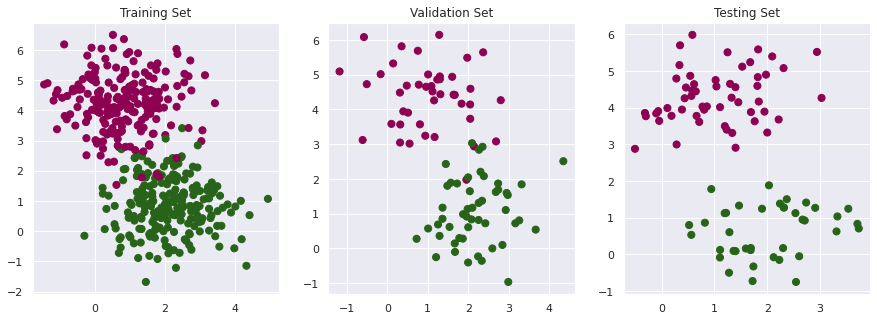

In [41]:
#@title Visualize Sets

from matplotlib import gridspec

fig, ax = plt.subplots(1, 3, 
                       gridspec_kw={
                           'width_ratios': [2, 2, 2],
                           'height_ratios': [1]},
                       figsize=(15,5))

ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG');
ax[0].set_title('Training Set')

ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, s=50, cmap='PiYG');
ax[1].set_title('Validation Set')

ax[2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG');
ax[2].set_title('Testing Set')

plt.show()

As with logistic regression, there are not a lot of hyperparameters that need tuning with SVMs.  The exception are details about the kernels that are used.  Play with the values in the SVC function.

* The kernel options you want to try are ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. 

* The degree is the degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

* The max_iter specifies the maximum number of itterations.  This is especially important for a linear kernel or it might continue indefinitely.  Notice that your results can decrease if the max_iter gets too high.

* The break_ties option being set to True will provide better results at the expense of computational time.



In [42]:
SVM_model = SVC(kernel='linear', degree=3, max_iter=500, break_ties=True) 
SVM_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=True, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=500, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

That's it!  Now lets use the model to predict the class labels for the validation set.

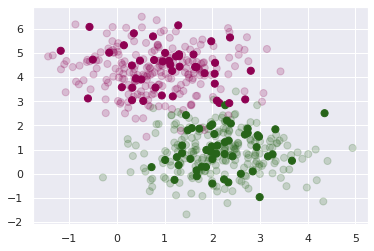

In [43]:
y_hat_svm = SVM_model.predict(X_val)

plt.figure(0)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_hat_svm, s=50, cmap='PiYG');

Metric     Value
---------  -------
Accuracy   0.97
Precision  0.98
Recall     0.96
F-score    0.97



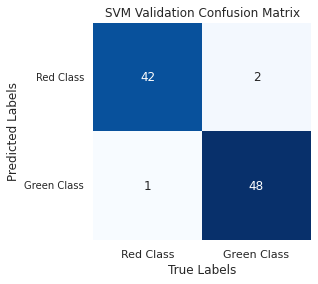

In [44]:
#@title Validation Evaluation

accuracy_svm = round(accuracy_score(y_val, y_hat_svm), 2)
precision_svm = round(precision_score(y_val, y_hat_svm), 2)
recall_svm = round(recall_score(y_val, y_hat_svm), 2)
fscore_svm = round(f1_score(y_val, y_hat_svm), 2)

print(tabulate([['Accuracy', accuracy_svm], 
                ['Precision', precision_svm],
                ['Recall', recall_svm],
                ['F-score', fscore_svm],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_svm = confusion_matrix(y_val, y_hat_svm)

ax = sns.heatmap(CM_svm.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("SVM Validation Confusion Matrix")
plt.show()

Now it's our chance to go back and modify the model hyperparameters until we get the best validation accuracy we can get.  

The hyperparameters you want to play with for this SVM model are the following:
* The kernel options you want to try are ‘linear’, ‘poly’, ‘rbf’, and ‘sigmoid’. 

* The degree is the degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

* The max_iter specifies the maximum number of itterations.  This is especially important for a linear kernel or it might continue indefinitely.  Notice that your results can decrease if the max_iter gets too high.

* The break_ties option being set to True will provide better results at the expense of computational time.


You will want to keep track of your accuracy scores for each set of hyperparameters that you try.  As before, there are more options that will be useful on more complex data.  See the documentation for more details: 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC

### Perform Final SVM Classification on the Test Set

Once you've tuned the hyperparameters in the model above to get the best possible results on the validation set (this probably won't be much work for this dataset), it's time to combine the original training and validation sets and create a new, final model.  We will then test this final model on our test set to estimate our model's effectiveness.

In [45]:
#Create final model
SVM_model_final = SVC(kernel='linear', degree=3, max_iter=500, break_ties=True) 
SVM_model_final.fit(X_final_train, y_final_train)

#Use the final model to predict the test data
y_hat_svm_final_test = SVM_model_final.predict(X_test)

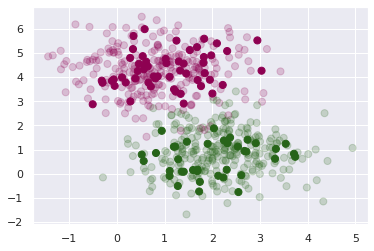

Metric     Value
---------  -------
Accuracy   1.0
Precision  1.0
Recall     1.0
F-score    1.0



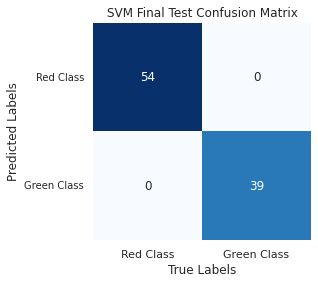

In [46]:
#@title Evaluate Final Model

plt.figure(0)
plt.scatter(X_final_train[:, 0], X_final_train[:, 1], c=y_final_train, s=50, cmap='PiYG', alpha=0.2);
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_svm_final_test, s=50, cmap='PiYG');
plt.show()

accuracy_svm_final = round(accuracy_score(y_test, y_hat_svm_final_test), 2)
precision_svm_final = round(precision_score(y_test, y_hat_svm_final_test), 2)
recall_svm_final = round(recall_score(y_test, y_hat_svm_final_test), 2)
fscore_svm_final = round(f1_score(y_test, y_hat_svm_final_test), 2)

print(tabulate([['Accuracy', accuracy_svm_final], 
                ['Precision', precision_svm_final],
                ['Recall', recall_svm_final],
                ['F-score', fscore_svm_final],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_svm = confusion_matrix(y_test, y_hat_svm_final_test)

ax = sns.heatmap(CM_svm.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("SVM Final Test Confusion Matrix")
plt.show()

# Multi-Class Logistic Regression Classification

So far we've been working with binary data, but most of these algorithms are trivially extended to multi-class classification, if it isn't automatic.

As an excercise, look at the sklearn documentation and see if you can create multi-class classifiers for the following synthetic data.  Logistic Regression has been done for you.

**NOTE: The Precision, Recall, and F-score are more difficult to calculate for multi-class scenarios.  In the example below, we remove them for simplicity and focus on the Confusion Matrix and Accuracy.**

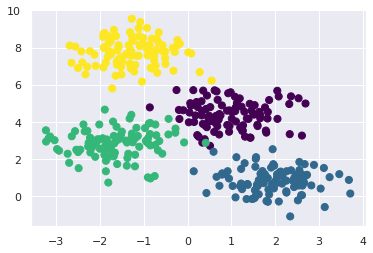

In [47]:
#@title Generate Multi-Class Data

Num_Classes = 4 #@param {type:"integer"}
Dataset_Size = 400 #@param {type:"slider", min:50, max:1000, step:10}
Standard_Deviation = 0.72 #@param {type:"slider", min:0, max:2, step:0.01}

#Let's make simple data to classify.
X_m, y_m = make_blobs(n_samples=Dataset_Size, 
                  centers=Num_Classes, 
                  random_state=0, 
                  cluster_std=Standard_Deviation)

plt.scatter(X_m[:, 0], X_m[:, 1], c=y_m, s=50, cmap='viridis');

#Break into train, validation, and test sets
X_m_train, X_m_remaining, y_m_train, y_m_remaining = \
    train_test_split(X_m, y_m, test_size=0.3)
X_m_test, X_m_val, y_m_test, y_m_val = \
    train_test_split(X_m_remaining, y_m_remaining, test_size=0.5)

## Multi-Class Logistic Regression Classification

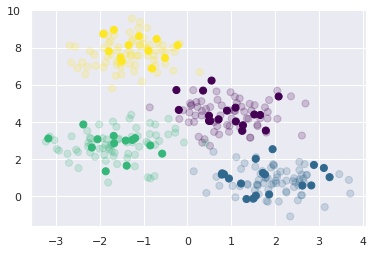

Metric    Value
--------  -------
Accuracy  0.98



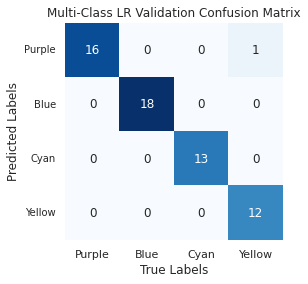

In [48]:
#@title Train and Validate

LR_m_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter=500)
LR_m_model.fit(X_m_train, y_m_train)

y_hat_m_lr = LR_m_model.predict(X_m_val)

#Visualize the classes
plt.figure(0)
plt.scatter(X_m_train[:, 0], X_m_train[:, 1], 
            c=y_m_train, s=50, cmap='viridis', alpha=0.2);
plt.scatter(X_m_val[:, 0], X_m_val[:, 1], 
            c=y_hat_m_lr, s=50, cmap='viridis');
plt.show()

#Calculate and print metrics
accuracy_lr_m = round(accuracy_score(y_m_val, y_hat_m_lr), 2)
print(tabulate([['Accuracy', accuracy_lr_m], 
                [' ', ' ']], 
               headers=['Metric', 'Value']))

#Calculate the confusion matrix
CM_lr_m = confusion_matrix(y_m_val, y_hat_m_lr)
ax = sns.heatmap(CM_lr_m.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

# The Confusion Matrix will be labeled for three or four classes, but not others
if Num_Classes == 3:
    ax.set_xticklabels(('Purple','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")
elif Num_Classes == 4:
    ax.set_xticklabels(('Purple','Blue','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Blue','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")

# Show the confusion matrix
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Multi-Class LR Validation Confusion Matrix")
plt.show()

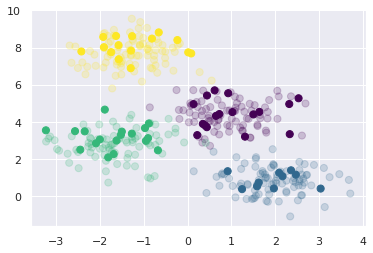

Metric    Value
--------  -------
Accuracy  1.0



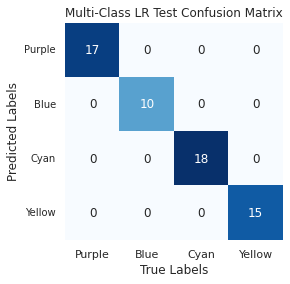

In [49]:
#@title Perform final tests

#Combine trainina and validation sets
X_m_final_train = np.concatenate((X_m_train, X_m_val), axis=0)
y_m_final_train = np.concatenate((y_m_train, y_m_val), axis=0)

#Create final model
LR_m_model_final = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100)
LR_m_model_final.fit(X_m_final_train, y_m_final_train)

#Use the final model to predict the test data
y_hat_m_lr_final_test = LR_m_model_final.predict(X_m_test)

#Visualize the classes
plt.figure(0)
plt.scatter(X_m_final_train[:, 0], X_m_final_train[:, 1], 
            c=y_m_final_train, s=50, cmap='viridis', alpha=0.2);
plt.scatter(X_m_test[:, 0], X_m_test[:, 1], 
            c=y_hat_m_lr_final_test, s=50, cmap='viridis');
plt.show()

#Calculate metrics
accuracy_logistic_m_final = round(accuracy_score(y_m_test, y_hat_m_lr_final_test), 2)

print(tabulate([['Accuracy', accuracy_logistic_m_final], 
                [' ', ' ']], 
               headers=['Metric', 'Value']))

#Calcuate confusion matrix
CM_logistic_m = confusion_matrix(y_m_test, y_hat_m_lr_final_test)
ax = sns.heatmap(CM_logistic_m.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

# The Confusion Matrix will be labeled for three or four classes, but not others
if Num_Classes == 3:
    ax.set_xticklabels(('Purple','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")
elif Num_Classes == 4:
    ax.set_xticklabels(('Purple','Blue','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Blue','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")

# Show the confusion matrix
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Multi-Class LR Test Confusion Matrix")
plt.show()

## Multi-Class SVM Classification

Your turn!  See if you can create a multi-class support vector machine classifier here.

In [54]:
#@title Train and Validate

In [57]:
#@title  Perform final tests


# Real-world Data

You've now worked with a couple of different small simulated datasets.  However, machine learning algorithms are most useful in large, real-world datasets.  

Below you'll find two different real-world datasets from sklearn set up for you to practice with.  One is a binary dataset (is a tumor cancerous or benign) while the other is multi-class (images of handwritten digits).

Try your hand at creating effective classifiers for these datasets.  See if you can match or beat my final test accuracy of:
* 94% - 95% for the Breast Cancer Dataset
* 99% for the Handwritten Digit Dataset

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

## Breast Cancer Diagnosis - Binary Classification

This dataset is built into sklearn.  It contains 569 data samples of breast tumors belonging to two classes - **malignant** or **benign**.  Here, benign is labeled "1" while malignant is labeled "0".

Each data sample is composed of 30 features, each computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

<center>
<div>
<img src="https://storage.googleapis.com/kaggle-datasets-images/180/384/3da2510581f9d3b902307ff8d06fe327/dataset-original.jpg" width="300"/>
</div>
</center>

The features are the mean, standard error, and "worst" of the following attributes:
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* smoothness (local variation in radius lengths)
* compactness (perimeter^2 / area - 1.0)
* concavity (severity of concave portions of the contour)
* concave points (number of concave portions of the contour)
* symmetry
* fractal dimension (“coastline approximation” - 1)

You can find more information about the data at:

https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

and

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

The following code gets you started:



In [ ]:
X_bc, y_bc = load_breast_cancer(return_X_y=True)

print("The first few features of the first few datapoints: \n", X_bc[:5,:7])
print("\nThe first 25 'answers': ", y_bc[1:25], "...")

The first few features of the first few datapoints: 
 [[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02]
 [1.969e+01 2.125e+01 1.300e+02 1.203e+03 1.096e-01 1.599e-01 1.974e-01]
 [1.142e+01 2.038e+01 7.758e+01 3.861e+02 1.425e-01 2.839e-01 2.414e-01]
 [2.029e+01 1.434e+01 1.351e+02 1.297e+03 1.003e-01 1.328e-01 1.980e-01]]

The first 25 'answers':  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0] ...


# SOLUTIONS TO THE ABOVE EXCERCISES..... DO NOT LOOK UNTIL FINISHED (or really, really stuck)
.

.

.

.

.

.

.

.

## Multi-Class SVM Classification

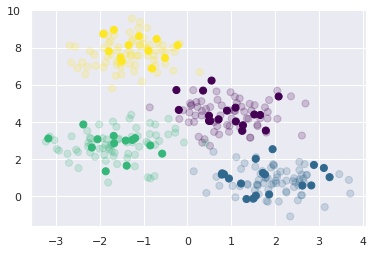

Metric    Value
--------  -------
Accuracy  0.98



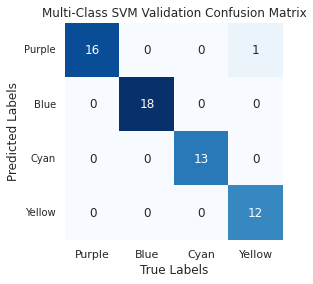

In [76]:
#@title Train and Validate
SVM_m_model = svm.SVC(decision_function_shape='ovo')
SVM_m_model.fit(X_m_train, y_m_train)

y_hat_m_svm = SVM_m_model.predict(X_m_val)

#Visualize the classes
plt.figure(0)
plt.scatter(X_m_train[:, 0], X_m_train[:, 1], 
            c=y_m_train, s=50, cmap='viridis', alpha=0.2);
plt.scatter(X_m_val[:, 0], X_m_val[:, 1], 
            c=y_hat_m_svm, s=50, cmap='viridis');
plt.show()

#Calculate and print metrics
accuracy_svm_m = round(accuracy_score(y_m_val, y_hat_m_svm), 2)
print(tabulate([['Accuracy', accuracy_svm_m], 
                [' ', ' ']], 
               headers=['Metric', 'Value']))

#Calculate the confusion matrix
CM_svm_m = confusion_matrix(y_m_val, y_hat_m_svm)
ax = sns.heatmap(CM_svm_m.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

# The Confusion Matrix will be labeled for three or four classes, but not others
if Num_Classes == 3:
    ax.set_xticklabels(('Purple','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")
elif Num_Classes == 4:
    ax.set_xticklabels(('Purple','Blue','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Blue','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")

# Show the confusion matrix
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Multi-Class SVM Validation Confusion Matrix")
plt.show()

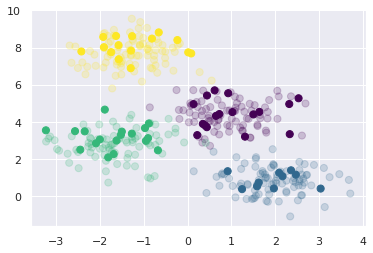

Metric    Value
--------  -------
Accuracy  1.0



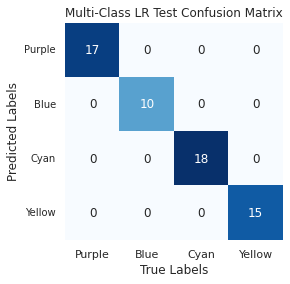

In [56]:
#@title  Perform final tests

#Create final model
SVM_m_model_final = svm.SVC(decision_function_shape='ovo')
SVM_m_model_final.fit(X_m_final_train, y_m_final_train)

#Use the final model to predict the test data
y_hat_m_svm_final_test = SVM_m_model_final.predict(X_m_test)

#Visualize the classes
plt.figure(0)
plt.scatter(X_m_final_train[:, 0], X_m_final_train[:, 1], 
            c=y_m_final_train, s=50, cmap='viridis', alpha=0.2);
plt.scatter(X_m_test[:, 0], X_m_test[:, 1], 
            c=y_hat_m_svm_final_test, s=50, cmap='viridis');
plt.show()

#Calculate metrics
accuracy_svm_m_final = round(accuracy_score(y_m_test, y_hat_m_svm_final_test), 2)

print(tabulate([['Accuracy', accuracy_svm_m_final], 
                [' ', ' ']], 
               headers=['Metric', 'Value']))

#Calcuate confusion matrix
CM_svm_m = confusion_matrix(y_m_test, y_hat_m_svm_final_test)
ax = sns.heatmap(CM_svm_m.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

# The Confusion Matrix will be labeled for three or four classes, but not others
if Num_Classes == 3:
    ax.set_xticklabels(('Purple','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")
elif Num_Classes == 4:
    ax.set_xticklabels(('Purple','Blue','Cyan','Yellow'))
    ax.set_yticklabels(('Purple','Blue','Cyan','Yellow'), 
        rotation=0, fontsize="10", va="center")

# Show the confusion matrix
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Multi-Class SVM Test Confusion Matrix")
plt.show()

## Breast Cancer Classification

Metric     Value
---------  -------
Accuracy   0.94
Precision  0.93
Recall     0.98
F-score    0.95



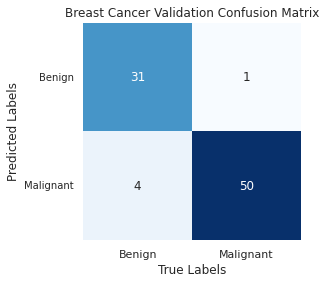

In [72]:
#@title Train and Validate
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

# Load the dataset
X_bc, y_bc = load_breast_cancer(return_X_y=True)

#Break into train, validation, and test sets
X_bc_train, X_bc_remaining, y_bc_train, y_bc_remaining = \
    train_test_split(X_bc, y_bc, test_size=0.3)
X_bc_test, X_bc_val, y_bc_test, y_bc_val = \
    train_test_split(X_bc_remaining, y_bc_remaining, test_size=0.5)

# Create the training model
bc_model = SVC(kernel='linear', degree=3, max_iter=-1) 
bc_model.fit(X_bc_train, y_bc_train)

# Run th emodel on the validation set
y_hat_bc_val = bc_model.predict(X_bc_val)

# Calculate evaluation metrics
accuracy_bc = round(accuracy_score(y_bc_val, y_hat_bc_val), 2)
precision_bc = round(precision_score(y_bc_val, y_hat_bc_val), 2)
recall_bc = round(recall_score(y_bc_val, y_hat_bc_val), 2)
fscore_bc = round(f1_score(y_bc_val, y_hat_bc_val), 2)

# Display evaluation metrics
print(tabulate([['Accuracy', accuracy_bc], 
                ['Precision', precision_bc],
                ['Recall', recall_bc],
                ['F-score', fscore_bc],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

# Calculate and display confusion matrix
CM_bc = confusion_matrix(y_bc_val, y_hat_bc_val)

ax = sns.heatmap(CM_bc.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Benign','Malignant'))
ax.set_yticklabels(('Benign','Malignant'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Breast Cancer Validation Confusion Matrix")
plt.show()

Metric     Value
---------  -------
Accuracy   0.95
Precision  0.92
Recall     1.0
F-score    0.96



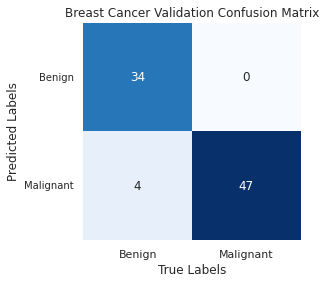

In [74]:
#@title Perform Final Tests

#Combine training and validation sets for final classification when we're ready 
#for our final classification after validation training/testing.
X_bc_final_train = np.concatenate((X_bc_train, X_bc_val), axis=0)
y_bc_final_train = np.concatenate((y_bc_train, y_bc_val), axis=0)

#Create final model
bc_model_final = SVC(kernel='linear', degree=3, max_iter=-1) 
bc_model_final.fit(X_bc_final_train, y_bc_final_train)

#Use the final model to predict the test data
y_hat_bc_final_test = bc_model_final.predict(X_bc_test)

# Calculate final evaluation metrics
accuracy_bc_final = round(accuracy_score(y_bc_test, y_hat_bc_final_test), 2)
precision_bc_final = round(precision_score(y_bc_test, y_hat_bc_final_test), 2)
recall_bc_final = round(recall_score(y_bc_test, y_hat_bc_final_test), 2)
fscore_bc_final = round(f1_score(y_bc_test, y_hat_bc_final_test), 2)

# Display evaluation metrics
print(tabulate([['Accuracy', accuracy_bc_final], 
                ['Precision', precision_bc_final],
                ['Recall', recall_bc_final],
                ['F-score', fscore_bc_final],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

# Calculate and display confusion matrix
CM_bc = confusion_matrix(y_bc_test, y_hat_bc_final_test)

ax = sns.heatmap(CM_bc.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Benign','Malignant'))
ax.set_yticklabels(('Benign','Malignant'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Breast Cancer Validation Confusion Matrix")
plt.show()